# Initialize TPU


In [0]:
# Run TPU https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/custom_training.ipynb#scrollTo=jwJtsCQhHK-E
from __future__ import absolute_import, division, print_function, unicode_literals

# Import TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import os

assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

assert float('.'.join(tf.__version__.split('.')[:2])) >= 1.14, 'Make sure that Tensorflow version is at least 1.14'

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system: 10.11.38.226:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.11.38.226:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2470844861955194015)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4799758195983654439)
INF

# Initiation and Uploading Cats-vs-Dogs


In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip training dataset
!unzip -uq '/content/drive/My Drive/Colab Notebooks/297-98_hw2/train.zip'
!unzip -uq '/content/drive/My Drive/Colab Notebooks/297-98_hw2/test.zip'
!unzip -uq '/content/drive/My Drive/Colab Notebooks/297-98_hw2/valid.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
unzip:  cannot find or open /content/drive/My Drive/Colab Notebooks/297-98_hw2/train.zip, /content/drive/My Drive/Colab Notebooks/297-98_hw2/train.zip.zip or /content/drive/My Drive/Colab Notebooks/297-98_hw2/train.zip.ZIP.
unzip:  cannot find or open /content/drive/My Drive/Colab Notebooks/297-98_hw2/test.zip, /content/drive/My Drive/Colab Notebooks/297-98_hw2/test.zip.zip or /content/drive/My Drive/Colab Notebooks/297-98_hw2/test.zip.ZIP.
unzip:  cannot find

In [0]:
import gzip
import numpy as np
import pandas as pd
from time import time
import keras,os


from sklearn.model_selection import train_test_split
# Migrate tensorflow https://www.tensorflow.org/guide/migrate
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
import keras.layers as layers
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam



import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


# LeNet


In [0]:
# Using 32x32 for LeNet
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/train", target_size=(32,32))


tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/valid", target_size=(32,32))

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


In [0]:
def build_model():
  model = keras.Sequential()

  model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.AveragePooling2D())

  model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(layers.AveragePooling2D())

  model.add(layers.Flatten())

  model.add(layers.Dense(units=120, activation='relu'))

  model.add(layers.Dense(units=84, activation='relu'))

  model.add(layers.Dense(units=2, activation = 'softmax'))

  return model

In [0]:
model = build_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_5 (Dense)              (None, 84)               

In [0]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [0]:
# steps per epoch = length of training data

checkpoint = ModelCheckpoint("leNet.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=len(traindata),generator=traindata, validation_data= testdata, validation_steps=10,epochs=100,callbacks=[checkpoint,early], shuffle=True)




Epoch 1/100





712/712 [==============================] - 69s 98ms/step - loss: 0.7526 - acc: 0.6209 - val_loss: 0.6004 - val_acc: 0.6875

Epoch 00001: val_acc improved from -inf to 0.68750, saving model to leNet.h5
Epoch 2/100
712/712 [==============================] - 62s 88ms/step - loss: 0.5871 - acc: 0.6868 - val_loss: 0.5780 - val_acc: 0.6781

Epoch 00002: val_acc did not improve from 0.68750
Epoch 3/100
712/712 [==============================] - 63s 88ms/step - loss: 0.5522 - acc: 0.7139 - val_loss: 0.5619 - val_acc: 0.6937

Epoch 00003: val_acc improved from 0.68750 to 0.69375, saving model to leNet.h5
Epoch 4/100
712/712 [==============================] - 62s 87ms/step - loss: 0.5143 - acc: 0.7436 - val_loss: 0.5434 - val_acc: 0.7031

Epoch 00004: val_acc improved from 0.69375 to 0.70312, saving model to leNet.h5
Epoch 5/100
712/712 [==============================] - 62s 88ms/step - loss: 0.4786 - acc: 0.7665 - val_loss: 0.5917 - val_acc: 0.7406

Epoch 00005: val_acc impr

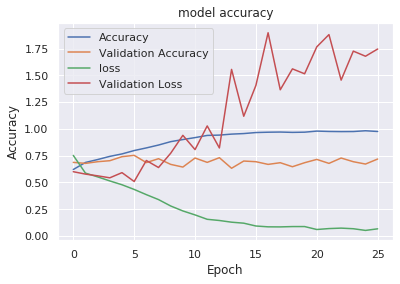

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

dog


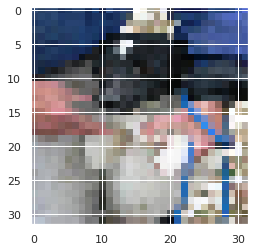

In [0]:
from keras.preprocessing import image
img = image.load_img("/content/test/1.jpg",target_size=(32,32))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("leNet.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')

# VGG

In [0]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/train", batch_size=64, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/valid", target_size=(224,224))

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


In [0]:
def build_model():
  model = Sequential()
  model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  # model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(Dense(units=4096))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Dense(units=2, activation="softmax"))

  return model

In [0]:
tf.keras.backend.clear_session()

opt = Adam(lr=0.005)

model = build_model()
model.summary()

model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 256) 

In [0]:
# steps per epoch = length of training data

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch= 50, generator=traindata, validation_data= testdata, validation_steps=10,epochs=100,callbacks=[checkpoint,early])




Epoch 1/100





50/50 [==============================] - 77s 2s/step - loss: 1.9656 - acc: 0.5320 - val_loss: 1.3128 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to vgg16_1.h5
Epoch 2/100
50/50 [==============================] - 48s 959ms/step - loss: 0.9735 - acc: 0.5469 - val_loss: 1.1413 - val_acc: 0.5594

Epoch 00002: val_acc improved from 0.50000 to 0.55937, saving model to vgg16_1.h5
Epoch 3/100
50/50 [==============================] - 48s 956ms/step - loss: 0.8526 - acc: 0.5494 - val_loss: 1.0509 - val_acc: 0.4813

Epoch 00003: val_acc did not improve from 0.55937
Epoch 4/100
50/50 [==============================] - 48s 957ms/step - loss: 0.8636 - acc: 0.5306 - val_loss: 7.3562 - val_acc: 0.4875

Epoch 00004: val_acc did not improve from 0.55937
Epoch 5/100
50/50 [==============================] - 48s 954ms/step - loss: 0.8679 - acc: 0.5497 - val_loss: 2.2968 - val_acc: 0.5031

Epoch 00005: val_acc did not improve from 0.55937
Epoch 6/1

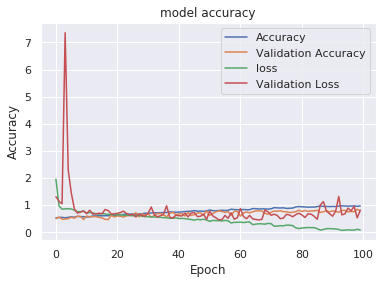

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

dog


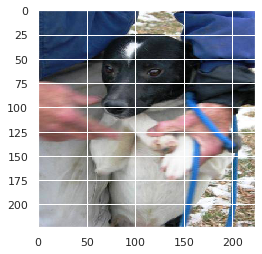

In [0]:
from keras.preprocessing import image
img = image.load_img("/content/test/1.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog') 
    

dog


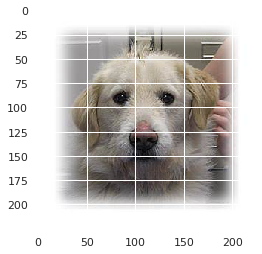

In [0]:
from keras.preprocessing import image
img = image.load_img("/content/test/3.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog') 
    

cat


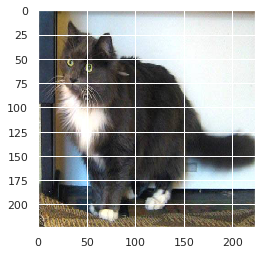

In [0]:
from keras.preprocessing import image
img = image.load_img("/content/test/9.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')